In [23]:
import sys 
import os 
import sounddevice as sd
import threading
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.pyplot import cm
import librosa
%matplotlib widget

In [24]:
os.chdir(r'C:\Users\NILS\Documents\ATIAM\Informatique\PROJET\electro-modelling\src')
sys.path.append('./src/')
from electro_modelling.models.base import GAN
from electro_modelling.helpers.helpers_audio import *
from electro_modelling.datasets.signal_processing import SignalOperators
from electro_modelling.datasets.techno_dataloader import techno_data_loader

In [25]:
sr = 16000
nfft =1024
nmels = int(nfft/8)
z_dims = 256
model = "wgan"
nb_samples=10

In [26]:

save_path = r'C:\Users\NILS\Documents\ATIAM\Informatique\PROJET\Runs\models_test_git\generator__wgan_img_size_128_128__init_kernel_2_2_minibatch_std__z_256__lr_0.0001__k_5__e_20.pt'
gif_path = r'C:\Users\NILS\Documents\ATIAM\Informatique\PROJET\Runs\models_test_git'


In [27]:
operator = SignalOperators(nfft,nmels,sr)
model = GAN(z_dims, model, init_weights=True,dataset='techno',img_chan=1,operator=operator)
generator = model.generator

#Load Generator
checkpoint = torch.load(save_path,map_location=torch.device('cpu'))
generator.load_state_dict(checkpoint['model_state_dict'])
model.generator=generator

# CHOIX DE LA TRAJECTOIRE

In [28]:
#Sample
trajectory = model.get_noise(nb_samples)

# CHILL

In [29]:
fakes = model.generator.forward(trajectory).detach().cpu()
fakes = fakes[:,:,:,:121]
sounds = model.get_sounds(fakes)
imix = 400
for i in range(sounds.shape[0]-1):
    sounds[i,-imix:] = sounds[i,-imix:] + sounds[i+1,:imix]
sounds = sounds[:,imix:].numpy()

fakes = torch.squeeze(fakes).numpy()
point_zero = fakes[0]

sound_compiled = sounds.reshape(-1)
len_sample = 2 * sounds[0].shape[0]/32000
len_total = len_sample*nb_samples

In [30]:
times = np.linspace(0, 2 , point_zero.shape[1])
freqs = librosa.mel_frequencies(
    n_mels=point_zero.shape[0], fmin=0.0, fmax=16000 / 2, htk=True
)

In [31]:
def add_colorbar(fig, ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")


In [32]:
def play():
    sd.play(sound_compiled,16000)

In [80]:
def compute_metrics(curSignal):
    dataStruct = dict.fromkeys(metrics_names)
    dataStruct["Loudness"] = librosa.feature.rms(curSignal)
    # Compute the spectral centroid. [y, sr, S, n_fft, ...]
    dataStruct["Centroid"] = librosa.feature.spectral_centroid(curSignal)
    # Compute the spectral bandwidth. [y, sr, S, n_fft, ...]
    dataStruct["Bandwidth"] = librosa.feature.spectral_bandwidth(curSignal)
    # Compute spectral contrast [R16] , sr, S, n_fft, ...])	
    dataStruct["Contrast"] = librosa.feature.spectral_contrast(curSignal)
    # Compute the spectral flatness. [y, sr, S, n_fft, ...]
    dataStruct["Flatness"] = librosa.feature.spectral_flatness(curSignal)
    # Compute roll-off frequency
    dataStruct["Rolloff"] = librosa.feature.spectral_rolloff(curSignal)
    return(dataStruct)

def compute_metrics_mean(dataStruct):
    dataStructMean = dict.fromkeys(metrics_names)
    for key in dataStructMean.keys():
        dataStructMean[key] = np.mean(dataStruct[key])
    return dataStructMean

In [181]:
curSignal = sound_compiled
metrics_names = ['Loudness', 'Centroid', "Bandwidth",  'Flatness', 'Rolloff','Contrast',] 
dataStructGlobal = compute_metrics(sound_compiled)
mean_metrics = []
for sound in sounds:
    dataStructTemp = compute_metrics(sound)
    dataStructMeans = compute_metrics_mean(dataStructTemp)
    mean_metrics.append(dataStructMeans)

In [86]:
mean_metrics[1]

{'Loudness': 0.20438959059284253,
 'Centroid': 1504.3592332323542,
 'Bandwidth': 2532.7752379358963,
 'Contrast': 21.854605654536737,
 'Flatness': 0.000400934042663645,
 'Rolloff': 3490.810074344758}

In [35]:
%matplotlib widget

C:\Users\NILS\AppData\Local\Temp/ipykernel_19284/3520671291.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax_quad.pcolormesh(X, Y, point_zero, cmap="magma",vmin=-1,vmax=1)


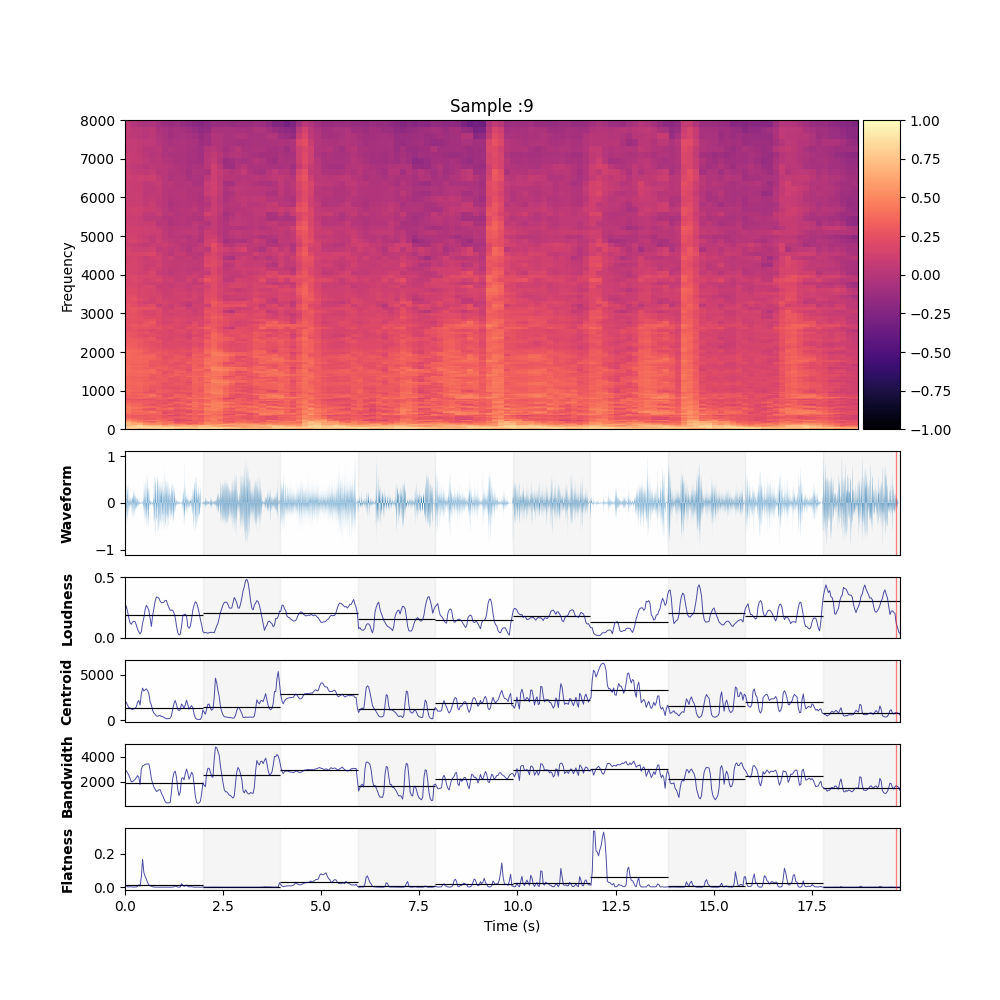

In [184]:
fig = plt.figure(figsize=(10,10))
spec = fig.add_gridspec(6,1,height_ratios = [0.75, 0.25, 0.15,0.15,0.15,0.15])

ax_quad = fig.add_subplot(spec[0, :])
ax_signal = fig.add_subplot(spec[1, :])

ax0 = fig.add_subplot(spec[2, :])
ax1 = fig.add_subplot(spec[3, :])
ax2 = fig.add_subplot(spec[4, :])
ax3 = fig.add_subplot(spec[5, :])

ax_metrics = [ax0,ax1,ax2,ax3]
vline_metrics = []
# ax = subfigs[0].subplots(2,1)#,figsize=(10,6))
# ax2 = subfigs[1].subplots(2,2)#,figsize=(10,4))

# ax_quad = ax[0]
# ax_signal = ax[1]


# SPECTROGRAM 

X, Y = np.meshgrid(times, freqs)
im0 = ax_quad.pcolormesh(X, Y, point_zero, cmap="magma",vmin=-1,vmax=1)
add_colorbar(fig, ax_quad, im0)
# ax_quad.set_xlabel(labelRow)
ax_quad.set_ylabel('Frequency')
ax_quad.set_title('Spectrogram')
ax_quad.set_xticks([])

# SIGNAL
total_times = np.linspace(0,len_total,sound_compiled.shape[0])
ax_signal.fill_between(total_times,sound_compiled)#,color='r',alpha=0.25)
ax_signal.set_xlim(0,total_times[-1])
color = ['whitesmoke','grey']#cm.seismic(np.linspace(0, 0.8,2))

ax_signal.set_xticks([])
for j in range(nb_samples):
    ax_signal.axvspan(len_sample*j,len_sample*(j+1),alpha=0.075,color=color[j%2])

ax_signal.set_ylabel('Waveform',weight='bold')
vl = ax_signal.axvline(0, ls='-', color='r',alpha=0.5,linewidth=0.9)


# METRICS

for n,ax in enumerate(ax_metrics):
    name = metrics_names[n]
    metric = dataStruct[name][0]
    metrics_times = np.linspace(0,total_times[-1],len(metric))
    h = ax.set_ylabel(name,weight='bold')
    ax.set_xlim(0,metrics_times[-1])
    # h.set_rotation(0)
    if n!=len(ax_metrics)-1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time (s)')

    ax.plot(metrics_times,metric,color='navy',alpha=0.7,linewidth=0.7)#,linestyle=((0, (1, 1))))
    
    len_sample_metric_sec =  metrics_times[-1]/nb_samples
    
    for j in range(nb_samples):
        ax.axvspan(len_sample_metric_sec*j,len_sample_metric_sec*(j+1),alpha=0.075,color=color[j%2])
        ax.hlines(mean_metrics[j][name],len_sample_metric_sec*j,len_sample_metric_sec*(j+1),color='k',linewidth=0.85)
    # vline_metrics.append(ax.axvline(0, ls='-', color='r'))
music_thread = threading.Thread(target=play,)

vl1 = ax0.axvline(0, ls='-', color='r',alpha=0.5,linewidth=0.9)
vl2 = ax1.axvline(0, ls='-', color='r',alpha=0.5,linewidth=0.9)
vl3 = ax2.axvline(0, ls='-', color='r',alpha=0.5,linewidth=0.9)
vl0 = ax3.axvline(0, ls='-', color='r',alpha=0.5,linewidth=0.9)


# ANIMATION 
sound_len = sounds[0].shape[0]
time_step_signal = int(sound_len/20)
nb_frames = int(len(sound_compiled)/time_step_signal)
j=1

def animate(i):
    # if i == 0:
        # music_thread.start()

    step = time_step_signal*i
    time =step/16000
    
    j = step//sound_len
    if step%sound_len==0:
        ax_quad.set_title('Sample :' + str(j))
        im0.set_array(fakes[j][:-1, :-1])
        j+=1
        
    vl.set_xdata([time,time])
    
    # for line in vlines_metrics:
    vl0.set_xdata([time,time])
    vl1.set_xdata([time,time])
    vl2.set_xdata([time,time])
    vl3.set_xdata([time,time])
    
    return im0,vl,vl1,vl2,vl3,vl0

def init():
    pass

# fig.tight_layout()
fig.align_ylabels([ax_quad,ax_signal,ax0,ax1,ax2,ax3])
frame_interval = time_step_signal/16000
fps = 1/frame_interval
anim = animation.FuncAnimation(fig,animate,frames=nb_frames,interval=frame_interval*1000,blit=True,repeat=False,init_func=init,cache_frame_data=False)
# plt.close(fig)
plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\NILS\Documents\ATIAM\Informatique\PROJET\ffmpeg-2022-01-10-git-f37e66b393-essentials_build\bin\ffmpeg.exe'
writer = animation.FFMpegWriter(fps=fps,bitrate=200)#, codec='libx264') # Or 
anim.save(filename="courbe.mp4", writer=writer)

# plt.show()


In [98]:
from IPython.display import HTML
HTML(anim.to_jshtml())

In [185]:
import ffmpeg
import soundfile
os.chdir(r'C:\Users\NILS\Documents\ATIAM\Informatique\PROJET\ffmpeg-2022-01-10-git-f37e66b393-essentials_build\bin')


audio_file =r'./audio.wav'
soundfile.write(audio_file, sound_compiled, 16000)


input_video = ffmpeg.input(r'./courbe.mp4')
input_audio = ffmpeg.input(audio_file)
ffmpeg.concat(input_video, input_audio, v=1, a=1).output('finished_video5.mp4').run()


(None, None)

In [231]:
# example of loading the generator model and generating images
import numpy as np
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# number of points before interpolation
nb_pts = 25
# latent space dimension
latent_dim = 256

# generate images
latent_points = generate_latent_points(latent_dim, nb_pts)
latent_points = latent_points/np.linalg.norm(latent_points,axis=1,keepdims=True) #Modification to enfore spherical initial points


# spherical linear interpolation (slerp)
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = slerp(ratio, p1, p2)
        vectors.append(v)
    return asarray(vectors)
 
pts_interpolation=10
# trajectories between nb_pts points
trajectories = np.empty((nb_pts-1,pts_interpolation,latent_dim))
for i in range(nb_pts-1):
    # spherical interpolation between 2 consecutive points
    trajectories[i,:] = interpolate_points(latent_points[i],latent_points[i+1],pts_interpolation)

#Là j'ai hésité à les concatenate pour faire une grande trajectoire mais les pas ne sont pas les mêmes donc c'est un peu dommage

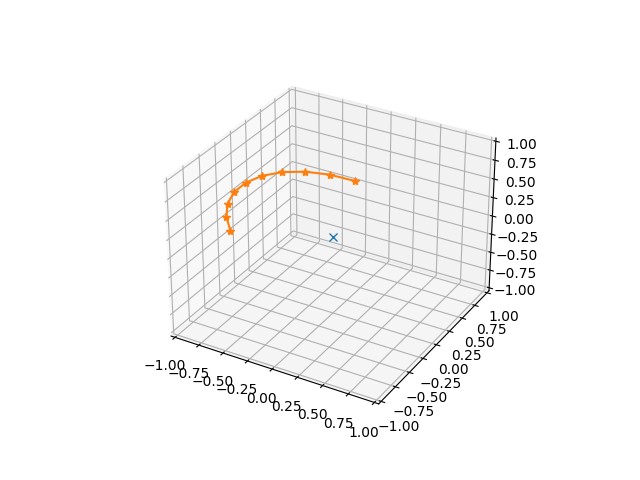

In [230]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

traj = trajectories[3]
plt.plot(0,0,0,marker='x')
plt.plot(traj[:,0],traj[:,1],traj[:,2],marker='*')

In [220]:
traj

array([[ 0.76978085, -0.56849733, -0.29025545],
       [ 0.72533359, -0.65062925, -0.22488389],
       [ 0.67146088, -0.72430646, -0.15659005],
       [ 0.60886276, -0.78857157, -0.08626137],
       [ 0.53835269, -0.84258946, -0.01481175],
       [ 0.46084691, -0.88565819,  0.05683033],
       [ 0.37735259, -0.91721811,  0.12773393],
       [ 0.2889547 , -0.9368591 ,  0.19697767],
       [ 0.19680195, -0.94432594,  0.26366175],
       [ 0.10209182, -0.93952158,  0.32691964]])